### Imports and Settings

In [8]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

import SAGA
from SAGA.database import FitsTable
from easyquery import Query
from easyquery import QueryMaker
from SAGA import ObjectCuts as C

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}

plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['legend.frameon'] = False
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 4

In [19]:
Mr_bins_fine = np.linspace(-22,12,5000)
Mr_bins = np.linspace(-22,-11,10)
Mr_limit = -12.3

r_bins = np.linspace(0,320,10)
r_bins_fine = np.linspace(0,300,5000)
rproj_limit = 300.

In [12]:
@jit
def N_gr_Mr_new(Mr,radii,prob,bins,radius_max,Mr_min):
    """
    Returns a luminosity function of surviving subhalos, subject to maxmimum
    distance and brightest magnitude.
    
    Args:
        Mr (array of floats): Magnitude of each subhalo
        radii (array of floats): Galacto-centric distance of each subhalo
        prob (array of floats): Survival probability of each subhalo
        bins (array of floats): Magnitude bin edges
        radius_max (float): Maximum radius within which to consider subhalos
        Mr_min (float): Brightest magnitude to which to consider subhalos
    
    Returns:
        Cumulative number of surviving subhalos less than each magnitude
    """
    bin_edges = np.hstack([-np.inf, bins])
    idx = (radii < radius_max) & (Mr > Mr_min) & np.isfinite(Mr)
    n = np.histogram(Mr[idx], bins=bin_edges, weights=prob[idx])[0]
    return np.cumsum(n)

In [17]:
@jit
def N_less_r(SubsMr,SubsRadii,prob,binsr,Mr_min):
    """
    Calculates the cumulative distribution function of Galactocentric radius, subject
    to some cuts on magnitude.
    
    Inputs:
        SubsMr (array): magnitudes of subhalos
        SubsRadii (array): Galactocentric radii of subhalos
        prob (array): distruption probabilities of subhalos
        binsr (array): Galactocentric radius bin edges
        Mr_min (float): Minimum subhalo magnitude to accept
    
    Returns:
        Array with length `binsr.size-1`, with number of subhalos at radii less than
        distances `binsr[1:]`.
    """
    idx = (SubsMr > Mr_min) & np.isfinite(SubsMr)
    SubsRadii = SubsRadii[idx]
    prob = prob[idx]
    n_in_bin = np.histogram(SubsRadii, bins=binsr, weights=prob)[0]
    return np.cumsum(n_in_bin)

In [24]:
@jit
def Mr_from_r(r,host_dist):
    return r - 5.*np.log10(host_dist) - 25.

### Load SAGA Data

In [3]:
saga = SAGA.QuickStart()
saga.set_default_base_version("paper2")
hosts = saga.host_catalog.load(include_stats=True)

SAGA `shared_dir` set to /Users/eon/Documents/PaperII
SAGA `local_dir`  set to /Users/eon/Documents/PaperII


In [26]:
completed_hosts = saga.host_catalog.load(query="paper2_complete", include_stats="remote")
observed_hosts = saga.host_catalog.load(query="paper2_observed", include_stats="remote")
bright_completed_hosts = saga.host_catalog.load(query="paper2_bright_complete", include_stats="remote")

sats_url = "https://www.dropbox.com/sh/7qeuqkq0c591k2g/AAC0c5C7erNCp0nYOhcDv9kva/saga_sats_latest.fits?dl=1"
sats = FitsTable(sats_url).read()
complete_host_query = saga.host_catalog.construct_host_query("paper2_complete")
sats_completed_hosts = complete_host_query.filter(sats)

url = "https://www.dropbox.com/sh/7qeuqkq0c591k2g/AADUIE4j1t2vXqKpaHoCY0L7a/saga_observed_latest.fits?dl=1"
specs_and_potential_sats = FitsTable(url).read()

specs = C.has_spec.filter(specs_and_potential_sats)
possible_sats = (~C.has_spec).filter(specs_and_potential_sats)

sats_this_host = {}
possible_sats_this_host = {}

hosts = set(specs_and_potential_sats["HOSTID"])
for host in hosts:
    sats_this_host[host] = (QueryMaker.equals("HOSTID", host) & C.is_sat).filter(specs_and_potential_sats)
    possible_sats_this_host[host] = (QueryMaker.equals("HOSTID", host)&(~C.has_spec)).filter(specs_and_potential_sats)

saga_colors = np.load('EON_data/color_dict.npz')

In [33]:
name_dict = {}
for key in saga_colors.keys():
    name_dict[key] = completed_hosts[completed_hosts['HOSTID']==key]['COMMON_NAME'][0]

In [23]:
saga_lfs_uncorrected = {}
saga_rs_uncorrected = {}

for host in completed_hosts['HOSTID']:
    sats = sats_completed_hosts[sats_completed_hosts['HOSTID']==host]
    saga_lfs_uncorrected[host] = N_gr_Mr_new(sats['Mr'],sats['RHOST_KPC'],np.ones(len(sats['Mr'])),Mr_bins_fine,
                                             rproj_limit,-25.)
    saga_rs_uncorrected[host] = (N_less_r(sats['Mr'],sats['RHOST_KPC'],np.ones(len(sats['Mr'])),r_bins_fine,-25.))

In [29]:
sats_num_draws = {}
num_draws = 1000
        
saga_lfs = {}

for host in completed_hosts['HOSTID']:
    saga_lfs[host] = []
    sats = sats_completed_hosts[sats_completed_hosts['HOSTID']==host]
    Mr_possible = Mr_from_r(possible_sats_this_host[host]['r_mag'],possible_sats_this_host[host]['HOST_DIST'])
    psat_possible = possible_sats_this_host[host]['p_sat_corrected']
    for j in range(num_draws):
        rands = np.random.rand(len(psat_possible))
        Mrs = np.concatenate((sats['Mr'],Mr_possible[rands<psat_possible]))
        rs = np.concatenate((sats['RHOST_KPC'],50.*np.ones(len(Mr_possible[rands<psat_possible]))))
        saga_lfs[host].append(N_gr_Mr_new(Mrs,rs,np.ones(len(Mrs)),Mr_bins_fine,rproj_limit,-25.))

<ipython-input-12-ec3bbce1b315>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "N_gr_Mr_new" failed type inference due to: No implementation of function Function(<function hstack at 0x118448200>) found for signature:
 
 >>> hstack(LiteralList((float64, array(float64, 1d, C))))
 
There are 2 candidate implementations:
    - Of which 1 did not match due to:
    Overload in function 'hstack': File: numba/core/typing/npydecl.py: Line 833.
      With argument(s): '(Poison<LiteralList((float64, array(float64, 1d, C)))>)':
     Rejected as the implementation raised a specific error:
       TypingError: Poison type used in arguments; got Poison<LiteralList((float64, array(float64, 1d, C)))>
  raised from /Users/eon/Library/Python/3.7/lib/python/site-packages/numba/core/types/functions.py:235
    - Of which 1 did not match due to:
    Overload in function 'hstack': File: numba/core/typing/npydecl.py: Line 833.
      With argument(s): '(Lit

### Load Simulation Data

In [22]:
with open('EON_data/LF_all_pred.pickle', 'rb') as handle:
    LF_all_pred = pickle.load(handle)
    
with open('EON_data/LF_all_pred_std.pickle', 'rb') as handle:
    LF_all_pred_std = pickle.load(handle)

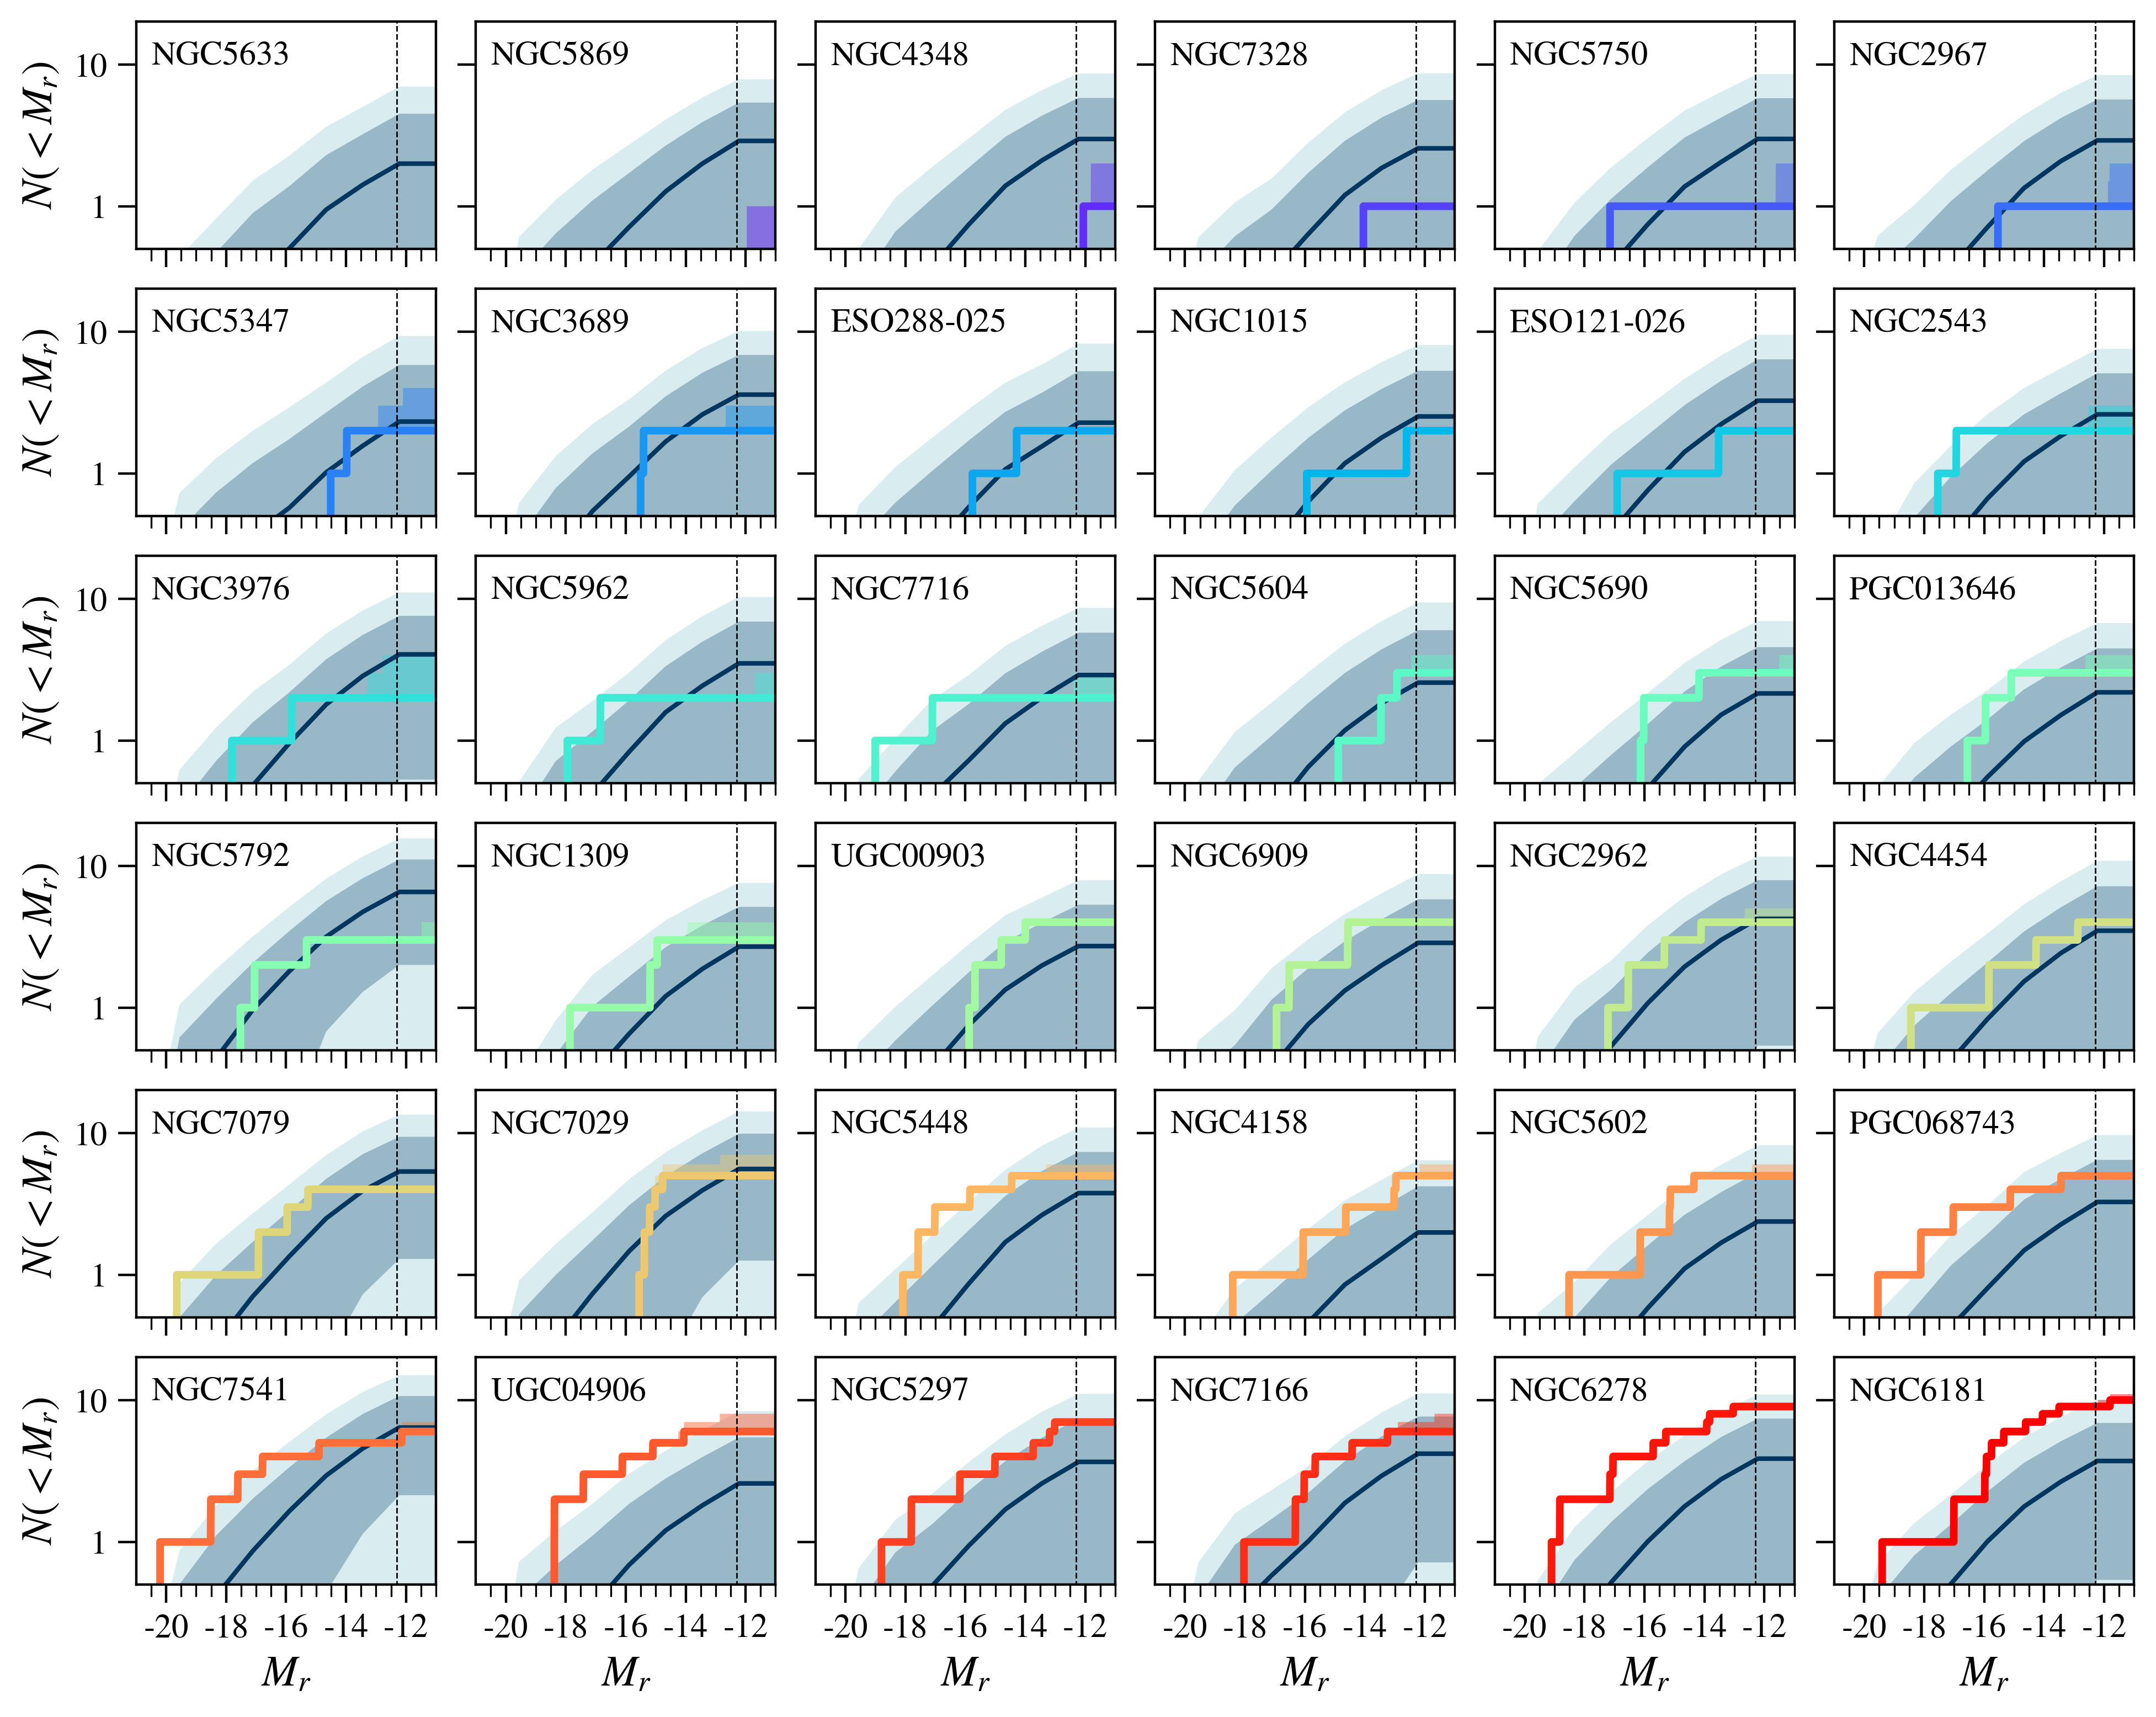

In [34]:
fig = plt.figure(figsize=(10,8))
position = range(1,len(np.unique(completed_hosts['HOSTID']))+1)

k=0
for saga_id in np.array(list(saga_colors.keys()))[::-1]:
    plt.subplot(6,6,position[k])
    plt.yscale('log')
    plt.fill_between(Mr_bins,(LF_all_pred[saga_id]-LF_all_pred_std[saga_id]).clip(min=1e-2),
                         LF_all_pred[saga_id]+LF_all_pred_std[saga_id],
                         facecolor="#003660",alpha=0.3,rasterized=True)
    plt.fill_between(Mr_bins,(LF_all_pred[saga_id]-2.*LF_all_pred_std[saga_id]).clip(min=1e-5),
                         LF_all_pred[saga_id]+2.*LF_all_pred_std[saga_id],
                         facecolor="#04859B",alpha=0.15,rasterized=True)
    plt.plot(Mr_bins,LF_all_pred[saga_id],lw=1.5,c="#003660")
    plt.plot(Mr_bins_fine,saga_lfs_uncorrected[saga_id],c=saga_colors[saga_id],lw=2.5,label='SAGA (Complete)')
    plt.fill_between(Mr_bins_fine,saga_lfs_uncorrected[saga_id],np.median(np.array(saga_lfs[saga_id]),axis=0),
                     facecolor=saga_colors[saga_id],alpha=0.45,rasterized=True)
    plt.plot(np.ones(10)*Mr_limit,np.linspace(0.1,40,10),'k--',lw=0.5)
    plt.xlim(-21,-11)
    plt.ylim(0.5,20)
    plt.text(-20.5,10,name_dict[saga_id],fontsize=11)
    if k in np.array([30,31,32,33,34,35]):
        plt.xlabel(r'$M_r$',fontsize=14)
        plt.xticks([-20,-18,-16,-14,-12],[-20,-18,-16,-14,-12],fontsize=11)
    else:
        plt.xticks([-20,-18,-16,-14,-12],['','','','',''])
    if k in np.array([0,6,12,18,24,30]):
        plt.ylabel(r'$N(<M_r)$',fontsize=14)
        plt.yticks([1,10],[1,10],fontsize=11)
    else:
        plt.yticks([1,10],['',''])
    k+=1

plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig('saga_lfs.pdf')
plt.show()

In [36]:
with open('EON_data/r_normed_pred.pickle', 'rb') as handle:
    r_normed_pred = pickle.load(handle)
    
with open('EON_data/r_normed_pred_std.pickle', 'rb') as handle:
    r_normed_pred_std = pickle.load(handle)

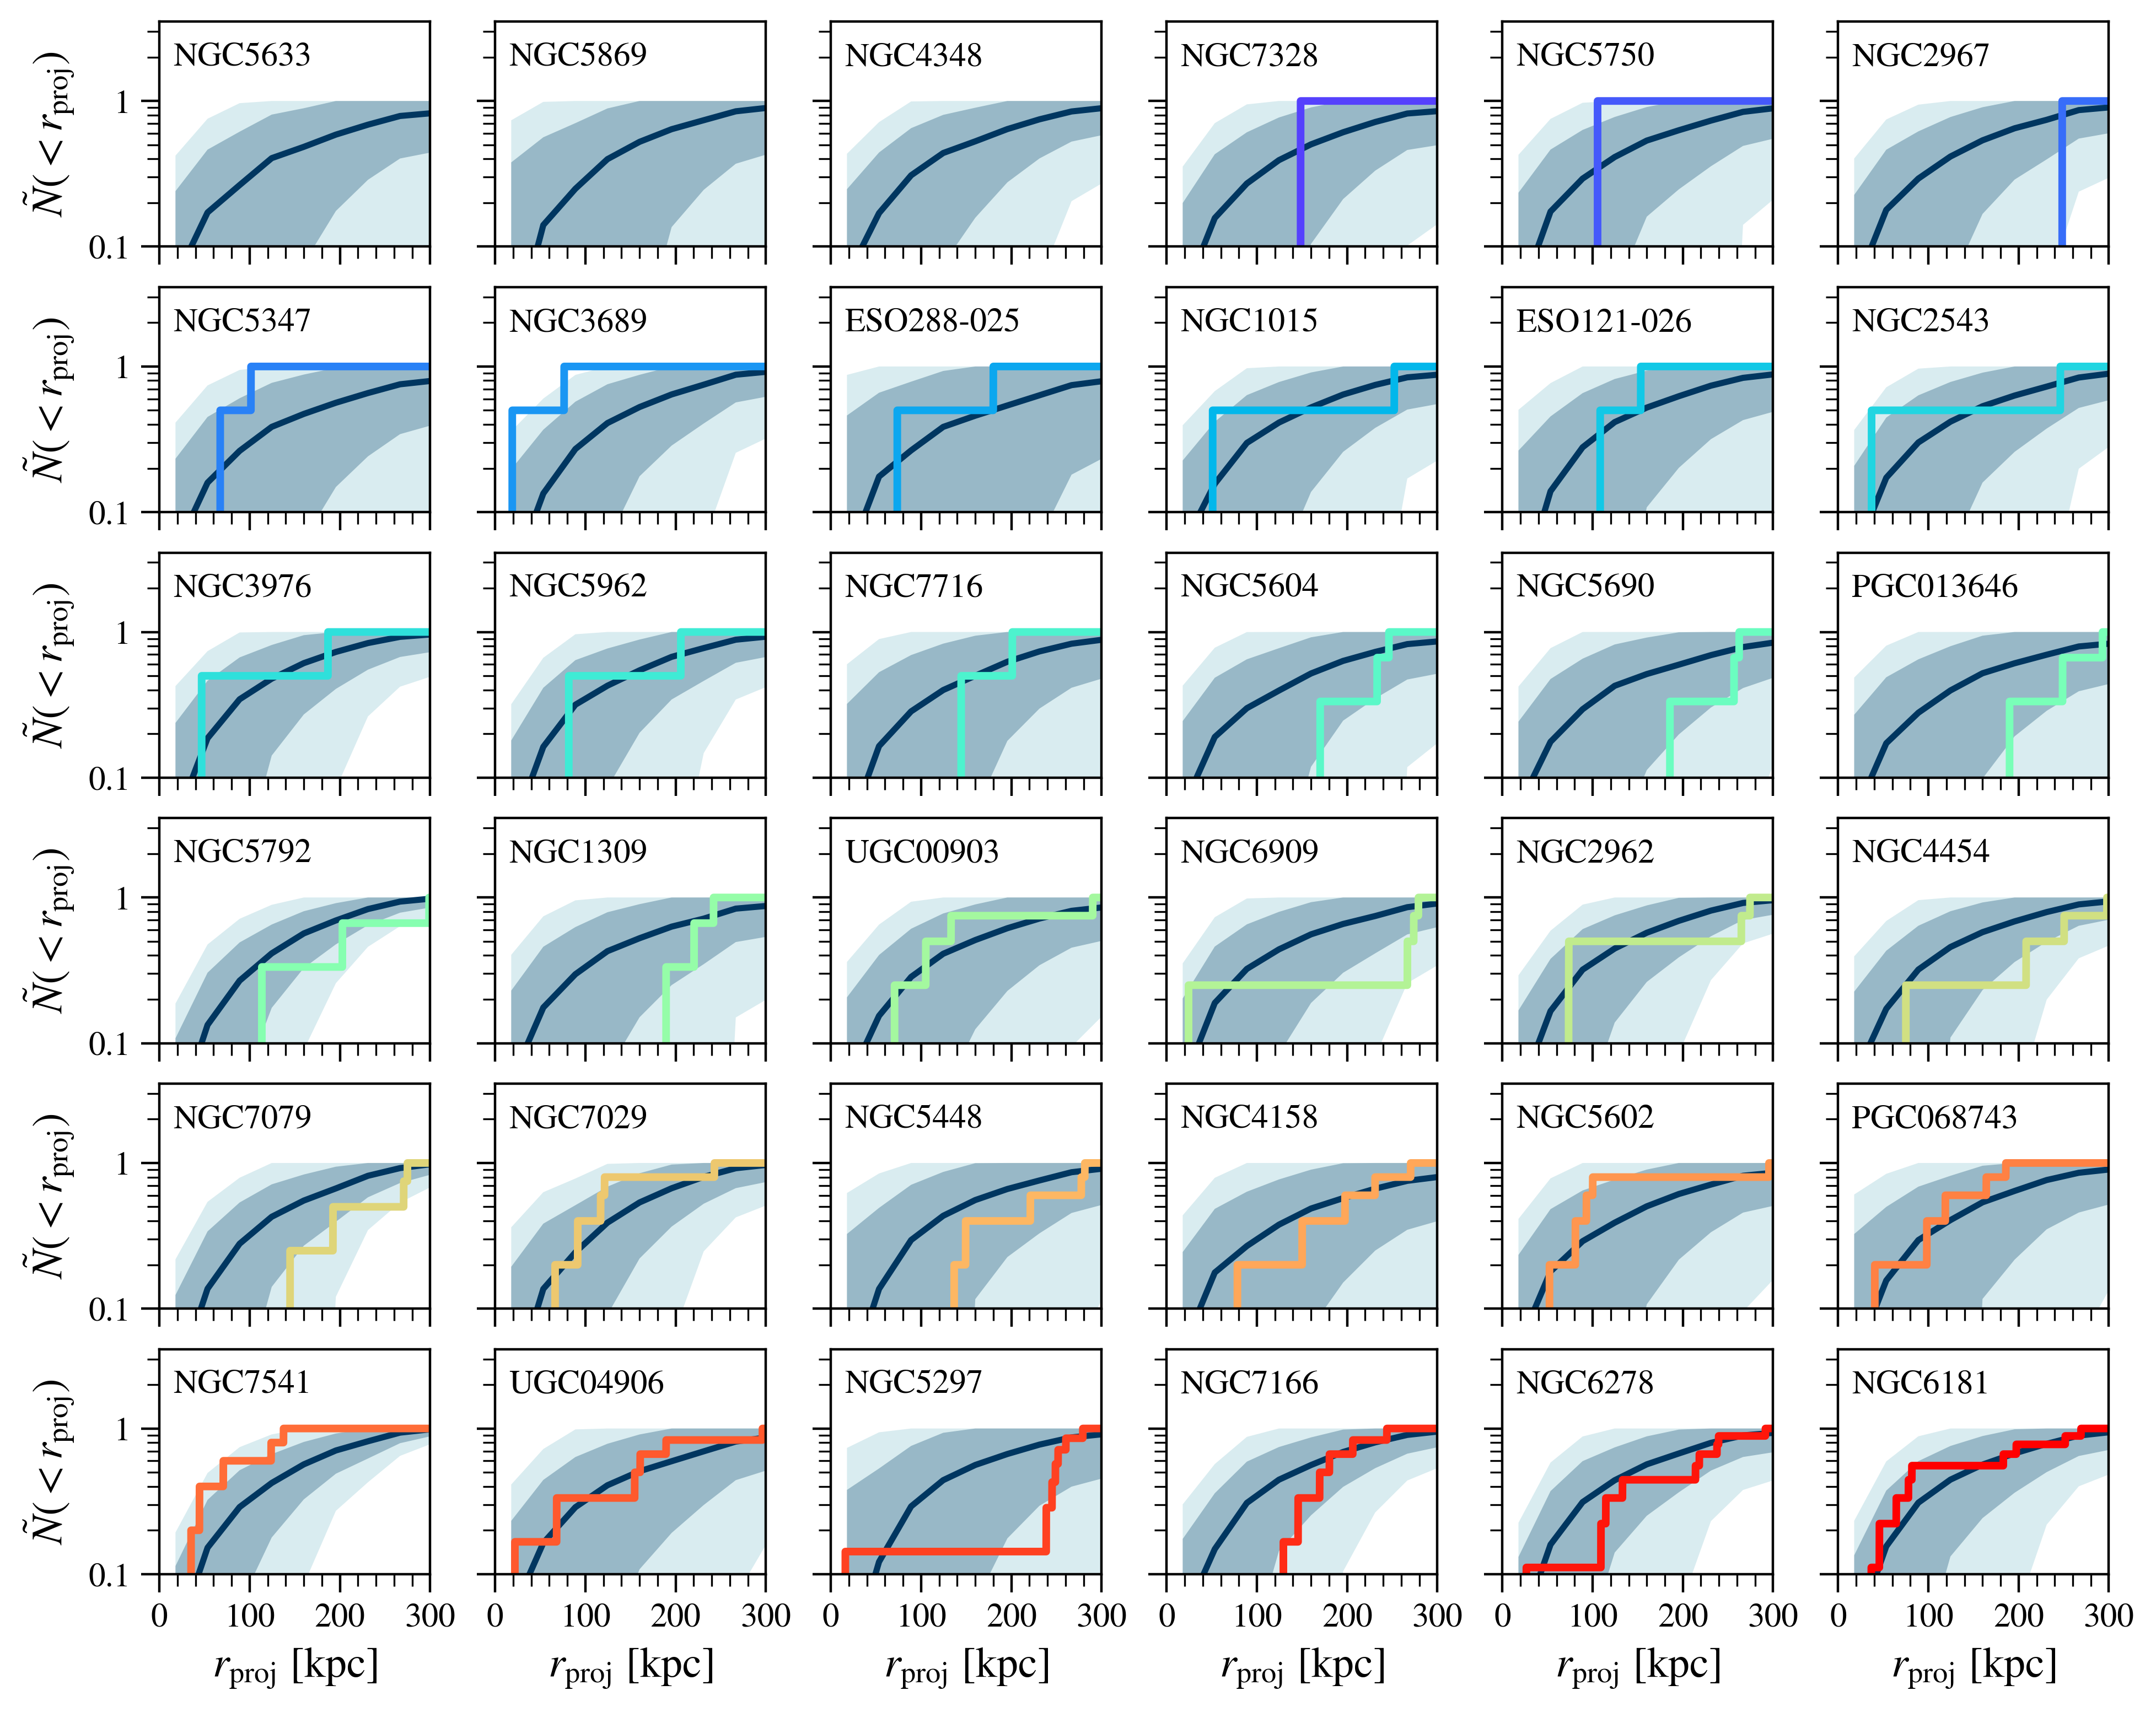

In [37]:
fig = plt.figure(figsize=(10,8))
position = range(1,len(np.unique(completed_hosts['HOSTID']))+1)

k=0
for saga_id in np.array(list(saga_colors.keys()))[::-1]:
    plt.subplot(6,6,position[k])
    plt.ylim(1,40)
    plt.yscale('log')
    plt.fill_between(0.5*(r_bins[0:-1]+r_bins[1:]),
                     (r_normed_pred[saga_id]-r_normed_pred_std[saga_id]).clip(min=1e-5),
                     (r_normed_pred[saga_id]+r_normed_pred_std[saga_id]).clip(max=1.),
                     facecolor="#003660",alpha=0.3)
    plt.fill_between(0.5*(r_bins[0:-1]+r_bins[1:]),
                     (r_normed_pred[saga_id]-2.*r_normed_pred_std[saga_id]).clip(min=1e-5),
                     (r_normed_pred[saga_id]+2.*r_normed_pred_std[saga_id]).clip(max=1.),
                     facecolor="#04859B",alpha=0.15)
    plt.plot(0.5*(r_bins[0:-1]+r_bins[1:]),r_normed_pred[saga_id],lw=2,c="#003660")
    idx = np.argmin(np.abs(Mr_bins_fine-Mr_limit))
    if 1.*saga_lfs_uncorrected[saga_id][idx] > 0:
        plt.plot(0.5*(r_bins_fine[0:-1]+r_bins_fine[1:]),
                 (1.*saga_rs_uncorrected[saga_id]/(1.*saga_lfs_uncorrected[saga_id][idx])).clip(max=1.),
                 c=saga_colors[saga_id],lw=2.5,label='SAGA (Complete)')
    plt.xlim(0,300)
    plt.ylim(0.1,3.5)
    plt.text(15.,1.75,name_dict[saga_id],fontsize=11)
    if k in np.array([30,31,32,33,34,35]):
        plt.xlabel(r'$r_{\rm{proj}}\ [\rm{kpc}]$',fontsize=14)
        plt.xticks([0,100,200,300],[0,100,200,300],fontsize=11)
    else:
        plt.xticks([0,100,200,300],['','','',''])
    if k in np.array([0,6,12,18,24,30]):
        plt.ylabel(r'$\tilde{N}(<r_{\rm{proj}})$',fontsize=14)
        plt.yticks([0.1,1],[0.1,1],fontsize=11)
    else:
        plt.yticks([0.1,1],['',''])
    k+=1
    
plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig('saga_radial.pdf')
plt.show()